In this Notebook we ensure functionality of all intermediate modules needed to build the full "Multi-Output Censored Heteroschedastic GP" for AAAI2020 paper. The steps will be the following:

- Justify switch back to "pyro logic"
- Gaussian likelihood GP
- Censored GP
- Censored Heteroschedastic GP
- Multi-output GP
- Censored multi-output GP
- Multi-output censored heteroschedastic GP

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import matplotlib.pyplot as plt
import tqdm 
import pandas as pd
import torch
import pyro
from pyro import distributions as dists
from pyro.infer import SVI, Trace_ELBO
from sklearn.metrics import r2_score

# custom imports
from models import VariationalGP, HeteroscedVariationalGP
from likelihoods import Gaussian, Poisson, NegBinomial, CensoredPoisson, CensoredHeteroscedGaussian, CensoredHomoscedGaussian, CensoredNegBinomial

plt.style.use("ggplot")

In [2]:
plt.style.use("ggplot")

##  1) Load NYC Bike data

In [3]:
# Load data
import pickle
with open('data_dict.pickle', 'rb') as f:
    dfs = pickle.load(f)

Time series length: 1465
Correlation coef: 0.6955535099609946


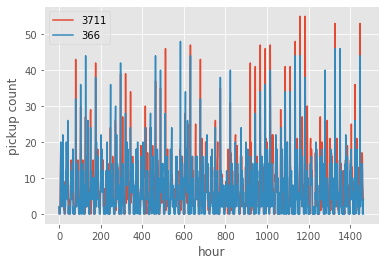

In [4]:
time_slice = pd.date_range(start='6/1/2018', end='8/1/2018', freq='1H')
print("Time series length:", len(time_slice))

base_st = 3711
other_st = 366

weather = dfs[base_st]["precip_prob"][time_slice].values

# Get data for Base Station
pickups_base = dfs[base_st]["pick-ups"][time_slice].values
dropoffs_base = dfs[base_st]["drop-offs"][time_slice].values

# Get data for Other Station
pickups_other = dfs[other_st]["pick-ups"][time_slice].values
dropoffs_other = dfs[other_st]["drop-offs"][time_slice].values

print("Correlation coef:", np.corrcoef(pickups_base, pickups_other)[0,1])

plt.plot(pickups_base[:])
plt.plot(pickups_other[:])
plt.xlabel("hour")
plt.ylabel("pickup count")
plt.legend([str(base_st), str(other_st)])
plt.show()

### Censor time-series 1

In [5]:
from datetime import timedelta

def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x)) 

np.set_printoptions(precision=2, suppress=True)

window_size = 1
balance_stats = []
for t in range(len(time_slice)):
    balance_stat = dfs[base_st]["drop-offs"][time_slice[t]-timedelta(hours=1)] - dfs[base_st]["pick-ups"][time_slice[t]-timedelta(hours=1)]
    balance_stats.append(balance_stat)
    
balance_stats = np.array(balance_stats)

censoring_probs = sigmoid(-balance_stats-5)

In [6]:
p = np.random.rand(len(censoring_probs))
censoring_locs = (p<censoring_probs).astype(np.int)
censoring_intensities = np.random.rand(len(censoring_probs))
censored_vals = (1-censoring_locs)*pickups_base + censoring_locs*(censoring_intensities*pickups_base).astype(np.int)

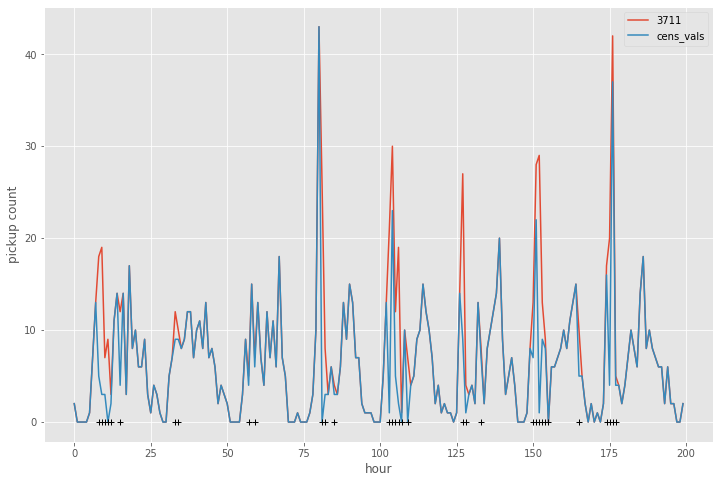

In [7]:
plt.figure(figsize=(12,8))
plt.plot(pickups_base[:200])
plt.plot(censored_vals[:200])
plt.plot(np.where(censoring_locs[:200]), np.zeros(len(np.where(censoring_locs[:200]))), 'k+')
plt.xlabel("hour")
plt.ylabel("pickup count")
plt.legend([str(base_st), "cens_vals"])
plt.show()

### Censor time-series 2

In [8]:
# manually censor second time-series
balance_stats2 = []
for t in range(len(time_slice)):
    balance_stat = dfs[other_st]["drop-offs"][time_slice[t]-timedelta(hours=1)] - dfs[other_st]["pick-ups"][time_slice[t]-timedelta(hours=1)]
    balance_stats2.append(balance_stat)
    
balance_stats2 = np.array(balance_stats2)
censoring_probs2 = sigmoid(-balance_stats2-5)

In [9]:
p = np.random.rand(len(censoring_probs2))
censoring_locs2 = (p<censoring_probs2).astype(np.int)
censoring_intensities2 = np.random.rand(len(censoring_probs2))
censored_vals2 = (1-censoring_locs2)*pickups_other + censoring_locs2*(censoring_intensities2*pickups_other).astype(np.int)

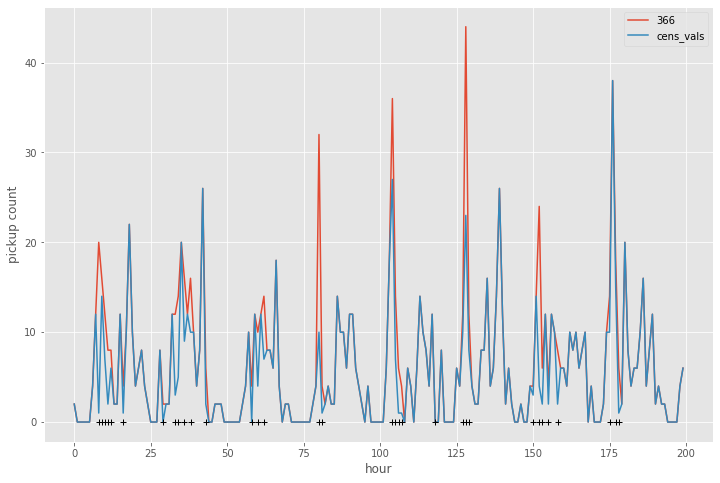

In [10]:
plt.figure(figsize=(12,8))
plt.plot(pickups_other[:200])
plt.plot(censored_vals2[:200])
plt.plot(np.where(censoring_locs2[:200]), np.zeros(len(np.where(censoring_locs2[:200]))), 'k+')
plt.xlabel("hour")
plt.ylabel("pickup count")
plt.legend([str(other_st), "cens_vals"])
plt.show()

### Train/test split and move to GPU

In [11]:
n_train = int(0.5*len(time_slice))
n_val = int(0.2*len(time_slice))
print("n_train:", n_train)
print("n_val:", n_val)
x = torch.arange(0,n_train).type(torch.float32)
x_cuda = x.cuda()
print(x.shape)
w = torch.from_numpy(weather[:n_train]).type(torch.float32)
w_mean = w.mean()
w_std = w.std()
w = (w - w_mean) / w_std
w_cuda = w.cuda()
print(w.shape)
#x = (x - x.mean()) / x.std()
y = torch.from_numpy(pickups_base[:n_train]).type(torch.float32)
y_mean = y.mean()
y_std = y.std()
y_counts = y[:].long()
y_counts_cuda = y_counts.cuda()
y = (y - y_mean) / y_std
y_cuda = y.cuda()
print(y.shape)
y_cens = torch.from_numpy(censored_vals[:n_train]).type(torch.float32)
y_cens_counts = y_cens[:].long()
y_cens_counts_cuda = y_cens_counts.cuda()
y_cens = (y_cens - y_mean) / y_std
y_cens_cuda = y_cens.cuda()
print(y_cens.shape)

x_val = torch.arange(n_train,n_train+n_val).type(torch.float32)
x_val_cuda = x_val.cuda()
print(x_val.shape)
w_val = torch.from_numpy(weather[n_train:(n_train+n_val)]).type(torch.float32)
w_val = (w_val - w_mean) / w_std
w_val_cuda = w_val.cuda()
print(w_val.shape)
y_val = torch.from_numpy(pickups_base[n_train:(n_train+n_val)]).type(torch.float32)
y_val_counts = y_val[:].long()
y_val_counts_cuda = y_val_counts.cuda()
y_val = (y_val - y_mean) / y_std
y_val_cuda = y_val.cuda()
print(y_val.shape)

x_test = torch.arange(n_train+n_val,len(time_slice)).type(torch.float32)
x_test_cuda = x_test.cuda()
print(x_test.shape)
w_test = torch.from_numpy(weather[(n_train+n_val):]).type(torch.float32)
w_test = (w_test - w_mean) / w_std
w_test_cuda = w_test.cuda()
print(w_test.shape)
y_test = torch.from_numpy(pickups_base[(n_train+n_val):]).type(torch.float32)
y_test_counts = y_test[:].long()
y_test_counts_cuda = y_test_counts.cuda()
y_test = (y_test - y_mean) / y_std
y_test_cuda = y_test.cuda()
print(y_test.shape)

n_train: 732
n_val: 293
torch.Size([732])
torch.Size([732])
torch.Size([732])
torch.Size([732])
torch.Size([293])
torch.Size([293])
torch.Size([293])
torch.Size([440])
torch.Size([440])
torch.Size([440])


In [12]:
# prepare second time-series
y2 = torch.from_numpy(pickups_other[:n_train]).type(torch.float32)
y2_mean = y2.mean()
y2_std = y2.std()
y2 = (y2 - y2_mean) / y2_std
y2_cuda = y2.cuda()
print(y2.shape)
y2_cens = torch.from_numpy(censored_vals2[:n_train]).type(torch.float32)
y2_cens_counts = y2_cens[:].long()
y2_cens_counts_cuda = y2_cens_counts.cuda()
y2_cens = (y2_cens - y2_mean) / y2_std
y2_cens_cuda = y2_cens.cuda()
print(y2_cens.shape)

y2_val = torch.from_numpy(pickups_other[n_train:(n_train+n_val)]).type(torch.float32)
y2_val = (y2_val - y2_mean) / y2_std
y2_val_cuda = y2_val.cuda()
print(y2_val.shape)

y2_test = torch.from_numpy(pickups_other[(n_train+n_val):]).type(torch.float32)
y2_test = (y2_test - y2_mean) / y2_std
y2_test_cuda = y2_test.cuda()
print(y2_test.shape)

torch.Size([732])
torch.Size([732])
torch.Size([293])
torch.Size([440])


### Prepare data for multi-output GPs

In [13]:
# Need to flatten both datasets in one vector with a one-hot-encoded feature set to indicate to which output every row
# belongs
x_mo = torch.cat((torch.stack([w, x], axis=-1), torch.stack([w, x], axis=-1)))
x_mo = torch.cat((x_mo, 
                    torch.cat((torch.ones(len(y),1), torch.zeros(len(y),1))), 
                    torch.cat((torch.zeros(len(y),1), torch.ones(len(y),1)))), 
                   dim=-1).cuda()
y_mo_cens = torch.cat((y_cens, y2_cens)).cuda()
y_mo_cens_counts = torch.cat((y_cens_counts, y2_cens_counts)).cuda()

In [14]:
# Need to flatten both datasets in one vector with a one-hot-encoded feature set to indicate to which output every row
# belongs
x_mo_val = torch.cat((torch.stack([w_val, x_val], axis=-1), torch.stack([w_val, x_val], axis=-1)))
x_mo_val = torch.cat((x_mo_val, 
                    torch.cat((torch.ones(len(y_val),1), torch.zeros(len(y_val),1))), 
                    torch.cat((torch.zeros(len(y_val),1), torch.ones(len(y_val),1)))), 
                   dim=-1).cuda()
y_mo_val = torch.cat((y_val, y2_val)).cuda()

In [15]:
# Need to flatten both datasets in one vector with a one-hot-encoded feature set to indicate to which output every row
# belongs
x_mo_test = torch.cat((torch.stack([w_test, x_test], axis=-1), torch.stack([w_test, x_test], axis=-1)))
x_mo_test = torch.cat((x_mo_test, 
                    torch.cat((torch.ones(len(y_test),1), torch.zeros(len(y_test),1))), 
                    torch.cat((torch.zeros(len(y_test),1), torch.ones(len(y_test),1)))), 
                   dim=-1).cuda()
y_mo_test = torch.cat((y_test, y2_test)).cuda()

In [16]:
censoring_locs_mo = np.concatenate((censoring_locs[:len(y)], censoring_locs2[:len(y2)]))

### Helper functions

In [17]:
def error_metrics(y, loc):
    loc = loc.cpu().detach().numpy()
    mae = torch.abs(y - loc).mean().numpy()
    rmse = torch.pow(y - loc, 2).mean().sqrt().numpy()
    r2 = r2_score(y, loc) 
    return mae, rmse, r2

def show_results(results, curves):
    print("Final results:\nTrain:\t\t\t\tVal:\t\t\t\tTest:")
    print("\tMAE=%.3f\t\t\tMAE=%.3f\t\t\tMAE=%.3f" % (best_res[0], best_res[3], best_res[6]))
    print("\tRMSE=%.3f\t\t\tRMSE=%.3f\t\t\tRMSE=%.3f" % (best_res[1], best_res[4], best_res[7]))
    print("\tR2=%.3f\t\t\tR2=%.3f\t\t\tR2=%.3f" % (best_res[2], best_res[5], best_res[8]))

    curves = np.array(curves)
    plt.plot(curves[:,0], curves[:,1])
    plt.plot(curves[:,0], curves[:,2])
    plt.plot(curves[:,0], curves[:,3])
    plt.xlabel("epoch")
    plt.ylabel("r2")
    plt.legend(["Train", "Val", "Test"])
    plt.show()

## 2.1) Gaussian GP on true data

In [18]:
# stupid model that predicts mean
print("Results for stupid model that predicts mean:")
test_mae = torch.abs(y - y.mean()).mean().numpy()
test_rmse = torch.pow(y - y.mean(), 2).mean().sqrt().numpy()
print("test_mae:", test_mae)
print("test_rmse:", test_rmse)

Results for stupid model that predicts mean:
test_mae: 0.7189854
test_rmse: 0.9993169


In [19]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

likelihood = Gaussian()
vgp = VariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_cuda, kernel=kernel, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [20]:
epochs = 20000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, y_mean+loc*y_std) # validation set

            loc, f_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, y_mean+loc*y_std) # train set

            loc, f_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, y_mean+loc*y_std) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 2000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 5378] ELBO: 685.4 - Best val: 0.410 (Test R2=0.365):  27%|██▋       | 5377/20000 [08:06<22:29, 10.84it/s] 

Final results:
Train:				Val:				Test:
	MAE=2.627			MAE=3.775			MAE=4.264
	RMSE=4.314			RMSE=6.259			RMSE=6.987
	R2=0.640			R2=0.391			R2=0.365


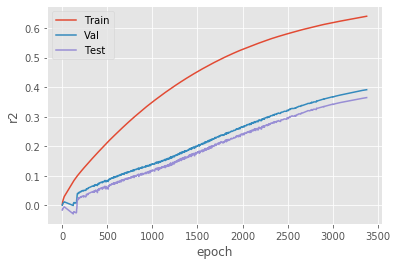

In [21]:
show_results(best_res, curves)

## 2.2) Gaussian GP on censored data

In [22]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

likelihood = Gaussian()
vgp = VariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_cens_cuda, kernel=kernel, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [23]:
epochs = 20000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, y_mean+loc*y_std) # validation set

            loc, f_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, y_mean+loc*y_std) # train set

            loc, f_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, y_mean+loc*y_std) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 2000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 7029] ELBO: 245.2 - Best val: 0.444 (Test R2=0.243):  35%|███▌      | 7028/20000 [10:32<18:48, 11.49it/s] 

Final results:
Train:				Val:				Test:
	MAE=2.661			MAE=3.759			MAE=4.443
	RMSE=4.988			RMSE=6.799			RMSE=7.628
	R2=0.519			R2=0.282			R2=0.243


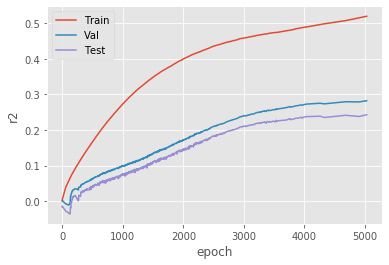

In [24]:
show_results(best_res, curves)

## 2.3) Censored Gaussian GP 

In [25]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

likelihood = CensoredHomoscedGaussian(censoring=torch.from_numpy(censoring_locs[:n_train]))
vgp = VariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_cens_cuda, kernel=kernel, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [26]:
epochs = 20000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, y_mean+loc*y_std) # validation set

            loc, f_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, y_mean+loc*y_std) # train set

            loc, f_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, y_mean+loc*y_std) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 2000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 5397] ELBO: 390.2 - Best val: 0.411 (Test R2=0.359):  27%|██▋       | 5397/20000 [07:33<17:27, 13.94it/s] 

Final results:
Train:				Val:				Test:
	MAE=2.738			MAE=3.849			MAE=4.216
	RMSE=4.677			RMSE=6.400			RMSE=7.019
	R2=0.577			R2=0.364			R2=0.359


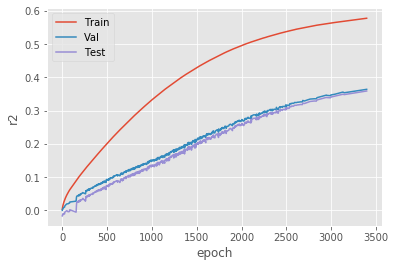

In [27]:
show_results(best_res, curves)

## 2.4) Censored Heteroscedastic GP 

In [28]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

kg1 = pyro.contrib.gp.kernels.WhiteNoise(1, torch.tensor(.2))
kg1.variance_unconstrained.requires_grad_(False)
kg2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
kg3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
kernel_g = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(kg1, kg2), kg3)

likelihood = CensoredHeteroscedGaussian(censoring=torch.from_numpy(censoring_locs[:n_train]))
vgp = HeteroscedVariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_cens_cuda, kernel=kernel, kernel_g=kernel_g, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [29]:
epochs = 40000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, y_mean+loc*y_std) # validation set

            loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, y_mean+loc*y_std) # train set

            loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, y_mean+loc*y_std) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 9294] ELBO: 314.2 - Best val: 0.421 (Test R2=0.363):  23%|██▎       | 9294/40000 [18:31<58:36,  8.73it/s]   

Final results:
Train:				Val:				Test:
	MAE=2.880			MAE=3.773			MAE=4.187
	RMSE=4.938			RMSE=6.361			RMSE=6.997
	R2=0.529			R2=0.371			R2=0.363


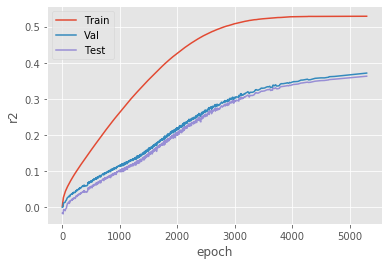

In [30]:
show_results(best_res, curves)

## 2.5) Censored Gaussian Multi-output GP

In [31]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
K = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)
B = pyro.contrib.gp.kernels.Coregionalize(input_dim=2, active_dims=[2,3])
kernel = pyro.contrib.gp.kernels.Product(K, B)

likelihood = CensoredHomoscedGaussian(censoring=torch.from_numpy(censoring_locs_mo).cuda())
vgp = VariationalGP(X=x_mo, y=y_mo_cens, kernel=kernel, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [32]:
epochs = 40000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(x_mo_val)

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[:len(y_val)][censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, y_mean+loc[:len(y_val)]*y_std) # validation set

            loc, f_cov = vgp(x_mo)
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, y_mean+loc[:len(y)]*y_std) # train set

            loc, f_cov = vgp(x_mo_test)
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, y_mean+loc[:len(y_test)]*y_std) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 8338] ELBO: 444.3 - Best val: 0.410 (Test R2=0.383):  21%|██        | 8338/40000 [14:27<53:51,  9.80it/s]   

Final results:
Train:				Val:				Test:
	MAE=2.320			MAE=3.738			MAE=4.150
	RMSE=4.181			RMSE=6.254			RMSE=6.886
	R2=0.662			R2=0.392			R2=0.383


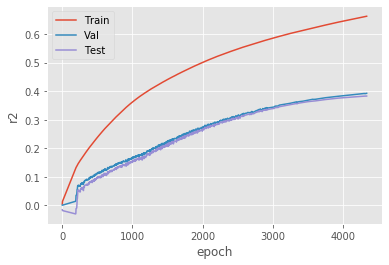

In [33]:
show_results(best_res, curves)

## 2.6) Multi-output Censored Heteroscedastic GP

In [34]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
K = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)
B = pyro.contrib.gp.kernels.Coregionalize(input_dim=2, active_dims=[2,3])
kernel = pyro.contrib.gp.kernels.Product(K, B)

kg1 = pyro.contrib.gp.kernels.WhiteNoise(1, torch.tensor(.2))
kg1.variance_unconstrained.requires_grad_(False)
kg2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
kg3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
#kg4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
#kg5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
#K2 = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)
K2 = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k1)
B2 = pyro.contrib.gp.kernels.Coregionalize(input_dim=2, active_dims=[2,3])
kernel_g = pyro.contrib.gp.kernels.Product(K2, B2)

likelihood = CensoredHeteroscedGaussian(censoring=torch.from_numpy(censoring_locs_mo).cuda())
vgp = HeteroscedVariationalGP(X=x_mo, y=y_mo_cens, kernel=kernel, kernel_g=kernel_g, likelihood=likelihood, whiten=False, jitter=1e-05, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [35]:
epochs = 40000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov, g_loc, g_cov = vgp(x_mo_val)

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[:len(y_val)][censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, y_mean+loc[:len(y_val)]*y_std) # validation set

            loc, f_cov, g_loc, g_cov = vgp(x_mo)
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, y_mean+loc[:len(y)]*y_std) # train set

            loc, f_cov, g_loc, g_cov = vgp(x_mo_test)
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, y_mean+loc[:len(y_test)]*y_std) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 9802] ELBO: 785.8 - Best val: 0.426 (Test R2=0.352):  25%|██▍       | 9802/40000 [28:30<1:26:26,  5.82it/s] 

Final results:
Train:				Val:				Test:
	MAE=2.479			MAE=3.778			MAE=4.209
	RMSE=4.665			RMSE=6.405			RMSE=7.057
	R2=0.579			R2=0.363			R2=0.352


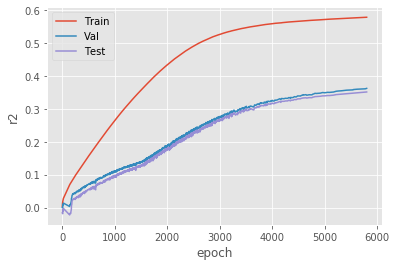

In [36]:
show_results(best_res, curves)

## 3.1) Poison GP on true data

In [37]:
y_means = torch.tensor([y_mean]*len(y)*10).cuda()

def mean_funct(X):
    return y_means[:len(X)]

In [38]:
hist_avg = y_cens_counts_cuda[:(24*7*4)].reshape([4,(24*7)]).float().mean(axis=0)

def mean_funct(X):
    return hist_avg[X.long()[:,1] % (24*7)].float()

In [40]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

resp_funct = torch.nn.Softplus()
likelihood = Poisson(response_function=resp_funct)
vgp = VariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_counts_cuda.float(), kernel=kernel, mean_function=mean_funct, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [41]:
epochs = 50000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))
        loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc) # validation set

            loc, f_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc) # train set

            loc, f_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 10798] ELBO: 1799.6 - Best val: 0.409 (Test R2=0.398):  22%|██▏       | 10797/50000 [13:03<50:06, 13.04it/s]

Final results:
Train:				Val:				Test:
	MAE=2.387			MAE=3.632			MAE=3.846
	RMSE=4.255			RMSE=6.365			RMSE=6.799
	R2=0.650			R2=0.371			R2=0.398


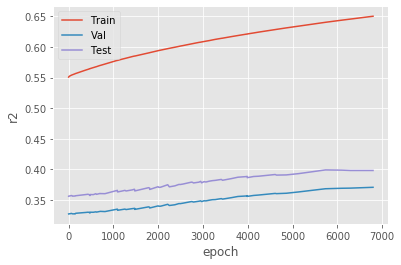

In [42]:
show_results(best_res, curves)

## 3.2) Poison GP on censored data

In [43]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

resp_funct = torch.nn.Softplus()
likelihood = Poisson(response_function=resp_funct)
vgp = VariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_cens_counts_cuda.float(), kernel=kernel, mean_function=mean_funct, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [44]:
epochs = 100000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))
        loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc) # validation set

            loc, f_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc) # train set

            loc, f_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 31555] ELBO: 1664.5 - Best val: 0.402 (Test R2=0.353):  32%|███▏      | 31554/100000 [37:36<1:24:54, 13.43it/s]

Final results:
Train:				Val:				Test:
	MAE=2.533			MAE=3.686			MAE=3.980
	RMSE=4.734			RMSE=6.605			RMSE=7.050
	R2=0.567			R2=0.322			R2=0.353


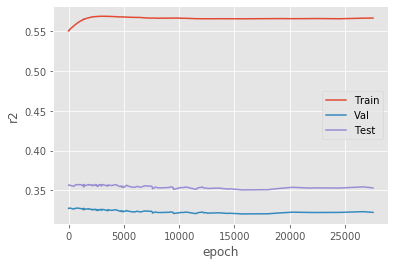

In [45]:
show_results(best_res, curves)

## 3.3) Censored Poison GP

In [46]:
y_means = torch.tensor([y_mean]*len(y)*10)

def mean_funct_cpu(X):
    return y_means[:len(X)]

In [47]:
hist_avg_cpu = y_cens_counts[:(24*7*4)].reshape([4,(24*7)]).float().mean(axis=0)

def mean_funct_cpu(X):
    return hist_avg_cpu[X.long()[:,1] % (24*7)].float()

In [48]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

resp_funct = torch.nn.Softplus()
likelihood = CensoredPoisson(censoring=torch.from_numpy(censoring_locs[:n_train]), response_function=resp_funct)
vgp = VariationalGP(X=torch.stack([w, x], axis=-1), y=y_cens_counts.float(), kernel=kernel, mean_function=mean_funct_cpu, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=False)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [49]:
epochs = 100000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(torch.stack([w_val, x_val], axis=-1))
        loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc) # validation set

            loc, f_cov = vgp(torch.stack([w, x], axis=-1))
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc) # train set

            loc, f_cov = vgp(torch.stack([w_test, x_test], axis=-1))
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 32076] ELBO: 1490.1 - Best val: 0.409 (Test R2=0.381):  32%|███▏      | 32076/100000 [2:55:19<6:14:02,  3.03it/s] 

Final results:
Train:				Val:				Test:
	MAE=2.544			MAE=3.653			MAE=3.873
	RMSE=4.697			RMSE=6.501			RMSE=6.896
	R2=0.574			R2=0.344			R2=0.381


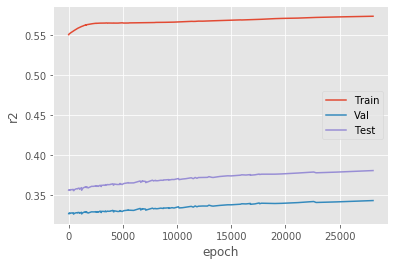

In [50]:
show_results(best_res, curves)

## 3.4) Multi-output Censored Poison GP

In [19]:
x_mo_cpu = x_mo.cpu()
x_mo_val_cpu = x_mo_val.cpu()
x_mo_test_cpu = x_mo_test.cpu()

In [ ]:
y_means = torch.tensor([y_mean]*len(y)*10)

def mean_funct_cpu_mo(X):
    return y_means[:len(X)]

In [ ]:
hist_avg1_cpu = y_cens_counts[:(24*7*4)].reshape([4,(24*7)]).float().mean(axis=0)
hist_avg2_cpu = y2_cens_counts[:(24*7*4)].reshape([4,(24*7)]).float().mean(axis=0)

def mean_funct_cpu_mo(X):
    idx = X.long()[:,1] % (24*7)
    return hist_avg1_cpu[idx].float() * X[:,-2] + hist_avg2_cpu[idx].float() * X[:,-1]

In [22]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
K = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)
B = pyro.contrib.gp.kernels.Coregionalize(input_dim=2, active_dims=[2,3])
kernel = pyro.contrib.gp.kernels.Product(K, B)

resp_funct = torch.nn.Softplus()
likelihood = CensoredPoisson(censoring=torch.from_numpy(censoring_locs_mo), response_function=resp_funct)
vgp = VariationalGP(X=x_mo.cpu(), y=y_mo_cens_counts.cpu(), kernel=kernel, likelihood=likelihood, mean_function=mean_funct_cpu_mo, whiten=False, jitter=1e-06, use_cuda=False)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [23]:
epochs = 50000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        loc, f_cov = vgp(x_mo_val_cpu)
        loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[:len(y_val)][censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc[:len(y_val)]) # validation set

            loc, f_cov = vgp(x_mo_cpu)
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc[:len(y)]) # train set

            loc, f_cov = vgp(x_mo_test_cpu)
            loc = resp_funct(torch.distributions.Normal(loc, f_cov.sqrt()).sample([10000])).mean(0) # MC approx.
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc[:len(y_test)]) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 49999] ELBO: 3030.3 - Best val: 0.377 (Test R2=0.422): 100%|██████████| 50000/50000 [17:01:32<00:00,  1.23s/it]  


Final results:
Train:				Val:				Test:
	MAE=2.451			MAE=3.692			MAE=3.847
	RMSE=4.384			RMSE=6.417			RMSE=6.666
	R2=0.629			R2=0.360			R2=0.422


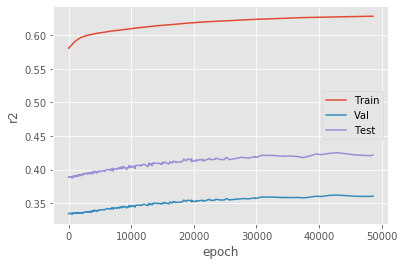

In [24]:
show_results(best_res, curves)

## 4.1) NegBinomial GP on true data

In [42]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

kg1 = pyro.contrib.gp.kernels.WhiteNoise(1, torch.tensor(.2))
kg1.variance_unconstrained.requires_grad_(False)
kg2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
kg3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
kg4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
kg5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel_g = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(kg3, kg2), kg4), kg5), kg1)

likelihood = NegBinomial()
vgp = HeteroscedVariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_counts_cuda, kernel=kernel, kernel_g=kernel_g, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [43]:
epochs = 40000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        f_loc, f_var, g_loc, g_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))
        mu = torch.nn.Softplus()(f_loc)
        alpha = torch.nn.Softplus()(g_loc)
        y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
        loc = y_dist.sample([1000]).mean(axis=0)

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc) # validation set

            f_loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc) # train set

            f_loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 23829] ELBO: 1872.8 - Best val: 0.453 (Test R2=0.365):  60%|█████▉    | 23829/40000 [1:13:01<46:56,  5.74it/s]  

Final results:
Train:				Val:				Test:
	MAE=2.671			MAE=3.585			MAE=4.057
	RMSE=4.249			RMSE=6.196			RMSE=6.984
	R2=0.651			R2=0.404			R2=0.365


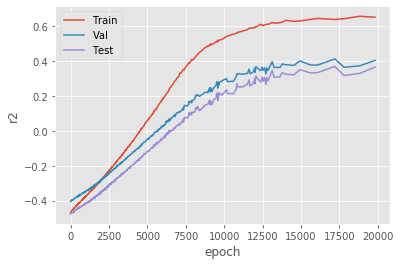

In [44]:
show_results(best_res, curves)

## 4.2) NegBinomial GP on censored data

In [45]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

kg1 = pyro.contrib.gp.kernels.WhiteNoise(1, torch.tensor(.2))
kg1.variance_unconstrained.requires_grad_(False)
kg2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
kg3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
kg4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
kg5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel_g = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(kg3, kg2), kg4), kg5), kg1)

likelihood = NegBinomial()
vgp = HeteroscedVariationalGP(X=torch.stack([w_cuda, x_cuda], axis=-1), y=y_cens_counts_cuda, kernel=kernel, kernel_g=kernel_g, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=True)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=5))
pyro.clear_param_store()

In [46]:
epochs = 40000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        f_loc, f_var, g_loc, g_cov = vgp(torch.stack([w_val_cuda, x_val_cuda], axis=-1))
        mu = torch.nn.Softplus()(f_loc)
        alpha = torch.nn.Softplus()(g_loc)
        y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
        loc = y_dist.sample([1000]).mean(axis=0)

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc) # validation set

            f_loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_cuda, x_cuda], axis=-1))
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc) # train set

            f_loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_test_cuda, x_test_cuda], axis=-1))
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 20764] ELBO: 1826.3 - Best val: 0.436 (Test R2=0.172):  52%|█████▏    | 20764/40000 [1:35:39<1:30:38,  3.54it/s]

Final results:
Train:				Val:				Test:
	MAE=3.168			MAE=3.835			MAE=4.589
	RMSE=5.677			RMSE=7.140			RMSE=7.977
	R2=0.377			R2=0.208			R2=0.172


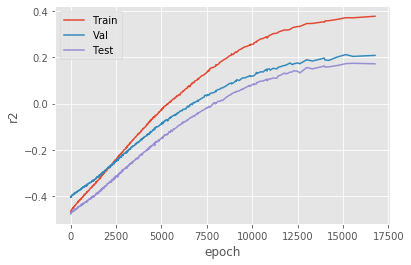

In [47]:
show_results(best_res, curves)

## 4.3) Censored NegBinomial GP

In [49]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.2))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)

kg1 = pyro.contrib.gp.kernels.WhiteNoise(1, torch.tensor(.2))
kg1.variance_unconstrained.requires_grad_(False)
kg2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
kg3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
kg4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
kg5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
kernel_g = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(kg3, kg2), kg4), kg5), kg1)

likelihood = CensoredNegBinomial(censoring=torch.from_numpy(censoring_locs[:n_train]))
vgp = HeteroscedVariationalGP(X=torch.stack([w, x], axis=-1), y=y_cens_counts, kernel=kernel, kernel_g=kernel_g, likelihood=likelihood, whiten=False, jitter=1e-06, use_cuda=False)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.0005}), Trace_ELBO(num_particles=5))
pyro.clear_param_store()

In [50]:
epochs = 100000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        f_loc, f_var, g_loc, g_cov = vgp(torch.stack([w_val, x_val], axis=-1))
        mu = torch.nn.Softplus()(f_loc)
        alpha = torch.nn.Softplus()(g_loc)
        y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
        loc = y_dist.sample([1000]).mean(axis=0)

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc) # validation set

            f_loc, f_cov, g_loc, g_cov = vgp(torch.stack([w, x], axis=-1))
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc) # train set

            f_loc, f_cov, g_loc, g_cov = vgp(torch.stack([w_test, x_test], axis=-1))
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 26753] ELBO: 1561.8 - Best val: 0.452 (Test R2=0.175):  27%|██▋       | 26753/100000 [5:52:04<13:10:35,  1.54it/s]

Final results:
Train:				Val:				Test:
	MAE=3.229			MAE=3.878			MAE=4.414
	RMSE=5.991			RMSE=7.279			RMSE=7.962
	R2=0.306			R2=0.177			R2=0.175


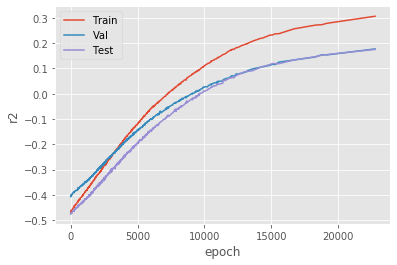

In [51]:
show_results(best_res, curves)

## 4.4) Multi-output Censored NegBinomial GP

In [57]:
x_mo_cpu = x_mo.cpu()
x_mo_val_cpu = x_mo_val.cpu()
x_mo_test_cpu = x_mo_test.cpu()

In [58]:
k1 = pyro.contrib.gp.kernels.WhiteNoise(input_dim=1, variance=torch.tensor(.5))
k1.variance_unconstrained.requires_grad_(False)
k2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
k3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
k4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
k5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
K = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)
B = pyro.contrib.gp.kernels.Coregionalize(input_dim=2, active_dims=[2,3])
kernel = pyro.contrib.gp.kernels.Product(K, B)

kg1 = pyro.contrib.gp.kernels.WhiteNoise(1, torch.tensor(.5))
kg1.variance_unconstrained.requires_grad_(False)
kg2 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[1])
kg3 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24.), active_dims=[1])
#kg4 = pyro.contrib.gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), active_dims=[0])
#kg5 = pyro.contrib.gp.kernels.Periodic(input_dim=1, variance=torch.tensor(1.), lengthscale=torch.tensor(1.), period=torch.tensor(24*7.), active_dims=[1])
#K2 = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k4), k5), k1)
K2 = pyro.contrib.gp.kernels.Sum(pyro.contrib.gp.kernels.Sum(k3, k2), k1)
B2 = pyro.contrib.gp.kernels.Coregionalize(input_dim=2, active_dims=[2,3])
kernel_g = pyro.contrib.gp.kernels.Product(K2, B2)

resp_funct = torch.nn.Softplus()
likelihood = CensoredNegBinomial(censoring=torch.from_numpy(censoring_locs_mo).cpu(), response_function=resp_funct)
vgp = HeteroscedVariationalGP(X=x_mo_cpu, y=y_mo_cens_counts.cpu(), kernel=kernel, kernel_g=kernel_g, likelihood=likelihood, whiten=False, jitter=1e-05, use_cuda=False)
svi = SVI(vgp.model, vgp.guide, pyro.optim.RMSprop({"lr": 0.001}), Trace_ELBO(num_particles=3))
pyro.clear_param_store()

In [59]:
epochs = 100000
losses = []
pbar = tqdm.tqdm(range(epochs), position=0, leave=True)

best_val_score = -np.inf # initialize validation metric
best_res = (0,0,0,0,0,0,0,0,0)
patience = 0
curves = []
for epoch in pbar:
    try:
        loss = svi.step()
        losses.append(loss)
        pbar.set_description("[Epoch {}] ELBO: {:.1f} - Best val: {:.3f} (Test R2={:.3f})" \
                                 .format(epoch, loss, best_val_score, best_res[-1]))
        
        f_loc, f_var, g_loc, g_cov = vgp(x_mo_val_cpu)
        mu = torch.nn.Softplus()(f_loc)
        alpha = torch.nn.Softplus()(g_loc)
        y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
        loc = y_dist.sample([1000]).mean(axis=0)

        # compute metric on (non-censored) validation data only
        val_score = r2_score(y_val_counts[censoring_locs[n_train:(n_train+n_val)] == 0], 
                             loc.cpu().detach().numpy()[:len(y_val)][censoring_locs[n_train:(n_train+n_val)] == 0]) 

        if val_score > best_val_score:
            best_val_score = val_score

            val_mae, val_rmse, val_r2 = error_metrics(y_val_counts, loc[:len(y_val)]) # validation set

            f_loc, f_cov, g_loc, g_cov = vgp(x_mo_cpu)
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            train_mae, train_rmse, train_r2 = error_metrics(y_counts, loc[:len(y)]) # train set

            f_loc, f_cov, g_loc, g_cov = vgp(x_mo_test_cpu)
            mu = torch.nn.Softplus()(f_loc)
            alpha = torch.nn.Softplus()(g_loc)
            y_dist = torch.distributions.negative_binomial.NegativeBinomial(total_count=1./alpha, logits=alpha*mu)
            loc = y_dist.sample([1000]).mean(axis=0)
            test_mae, test_rmse, test_r2 = error_metrics(y_test_counts, loc[:len(y_test)]) # test set

            best_res = (train_mae, train_rmse, train_r2, val_mae, val_rmse, val_r2, test_mae, test_rmse, test_r2)
            curves.append([epoch, train_r2, val_r2, test_r2])
            patience = 0
        else:
            patience += 1

        if patience > 4000: # maximum number of iterations allowed without improving val score
            break # stop training
                
    except KeyboardInterrupt:
        break

[Epoch 18305] ELBO: 3210.4 - Best val: 0.436 (Test R2=0.184):  18%|█▊        | 18305/100000 [9:53:32<38:32:59,  1.70s/it]

Final results:
Train:				Val:				Test:
	MAE=3.536			MAE=4.036			MAE=4.603
	RMSE=6.198			RMSE=7.287			RMSE=7.920
	R2=0.257			R2=0.175			R2=0.184


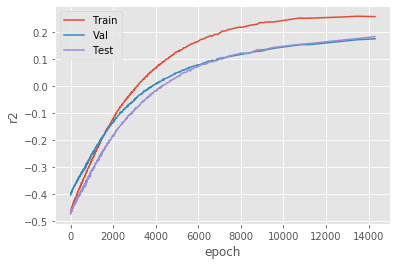

In [60]:
show_results(best_res, curves)